In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [2]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

batch_size = 128


In [3]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = idx[:split_point]
test_idx = idx[split_point:]

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [4]:
train_dataset.dataset.label

tensor([ 7,  7,  7,  ..., 28,  3,  2], device='cuda:0')

In [5]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = np.concatenate([indices[:start], indices[end:]])
        trainval_indices = indices[start:end]
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        learning_rate = 0.1
        hidden_dim = 128

        # Initialize model and transfer to GPU
        model = MoannaModel(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.4139, Train Acc=0.1037, Val Acc=0.1560, Test Acc=0.1679
Fold 1/5, Epoch 2: Train Loss=3.2205, Train Acc=0.1556, Val Acc=0.1728, Test Acc=0.1806
Fold 1/5, Epoch 3: Train Loss=3.0718, Train Acc=0.1792, Val Acc=0.1767, Test Acc=0.1974
Fold 1/5, Epoch 4: Train Loss=2.9479, Train Acc=0.1955, Val Acc=0.1953, Test Acc=0.2332
Fold 1/5, Epoch 5: Train Loss=2.8277, Train Acc=0.2437, Val Acc=0.2455, Test Acc=0.2861
Fold 1/5, Epoch 6: Train Loss=2.7042, Train Acc=0.2792, Val Acc=0.2864, Test Acc=0.3336
Fold 1/5, Epoch 7: Train Loss=2.5866, Train Acc=0.3189, Val Acc=0.3219, Test Acc=0.3631
Fold 1/5, Epoch 8: Train Loss=2.4725, Train Acc=0.3472, Val Acc=0.3221, Test Acc=0.3781
Fold 1/5, Epoch 9: Train Loss=2.3555, Train Acc=0.3799, Val Acc=0.3455, Test Acc=0.4093
Fold 1/5, Epoch 10: Train Loss=2.2607, Train Acc=0.4151, Val Acc=0.3633, Test Acc=0.4556
Fold 1/5, Epoch 11: Train Loss=2.1691, Train Acc=0.4491, Val Acc=0.3910, Test Acc=0.5136
Fold 1/

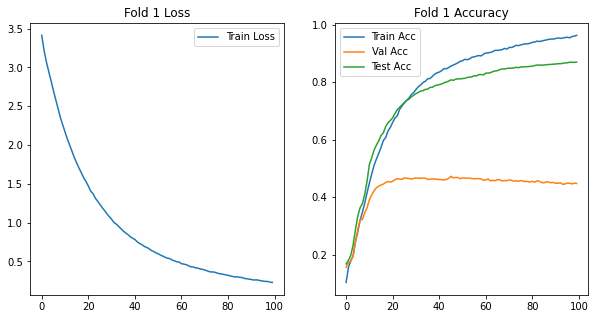

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.4122, Train Acc=0.1059, Val Acc=0.1550, Test Acc=0.1624
Fold 2/5, Epoch 2: Train Loss=3.2204, Train Acc=0.1485, Val Acc=0.1793, Test Acc=0.2018
Fold 2/5, Epoch 3: Train Loss=3.0823, Train Acc=0.1687, Val Acc=0.1818, Test Acc=0.2053
Fold 2/5, Epoch 4: Train Loss=2.9556, Train Acc=0.1999, Val Acc=0.2053, Test Acc=0.2455
Fold 2/5, Epoch 5: Train Loss=2.8281, Train Acc=0.2421, Val Acc=0.2408, Test Acc=0.2985
Fold 2/5, Epoch 6: Train Loss=2.7092, Train Acc=0.2881, Val Acc=0.2730, Test Acc=0.3388
Fold 2/5, Epoch 7: Train Loss=2.5806, Train Acc=0.3234, Val Acc=0.2979, Test Acc=0.3653
Fold 2/5, Epoch 8: Train Loss=2.4671, Train Acc=0.3499, Val Acc=0.3010, Test Acc=0.3806
Fold 2/5, Epoch 9: Train Loss=2.3544, Train Acc=0.3749, Val Acc=0.3145, Test Acc=0.4100
Fold 2/5, Epoch 10: Train Loss=2.2595, Train Acc=0.4105, Val Acc=0.3501, Test Acc=0.4681
Fold 2/5, Epoch 11: Train Loss=2.1658, Train Acc=0.4506, Val Acc=0.3693, Test Acc=0.4935
Fold 2/

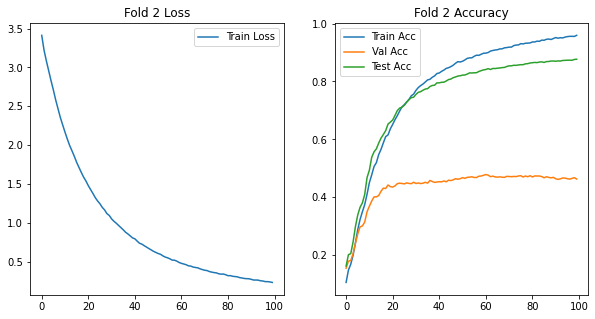

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.4036, Train Acc=0.1223, Val Acc=0.1357, Test Acc=0.1501
Fold 3/5, Epoch 2: Train Loss=3.2144, Train Acc=0.1563, Val Acc=0.1594, Test Acc=0.1851
Fold 3/5, Epoch 3: Train Loss=3.0758, Train Acc=0.1807, Val Acc=0.1937, Test Acc=0.2264
Fold 3/5, Epoch 4: Train Loss=2.9547, Train Acc=0.2073, Val Acc=0.1818, Test Acc=0.2209
Fold 3/5, Epoch 5: Train Loss=2.8408, Train Acc=0.2376, Val Acc=0.2366, Test Acc=0.2836
Fold 3/5, Epoch 6: Train Loss=2.7187, Train Acc=0.2833, Val Acc=0.2721, Test Acc=0.3322
Fold 3/5, Epoch 7: Train Loss=2.5982, Train Acc=0.3163, Val Acc=0.2935, Test Acc=0.3537
Fold 3/5, Epoch 8: Train Loss=2.4783, Train Acc=0.3398, Val Acc=0.2994, Test Acc=0.3742
Fold 3/5, Epoch 9: Train Loss=2.3727, Train Acc=0.3674, Val Acc=0.3157, Test Acc=0.4001
Fold 3/5, Epoch 10: Train Loss=2.2746, Train Acc=0.4003, Val Acc=0.3237, Test Acc=0.4285
Fold 3/5, Epoch 11: Train Loss=2.1874, Train Acc=0.4340, Val Acc=0.3661, Test Acc=0.4907
Fold 3/

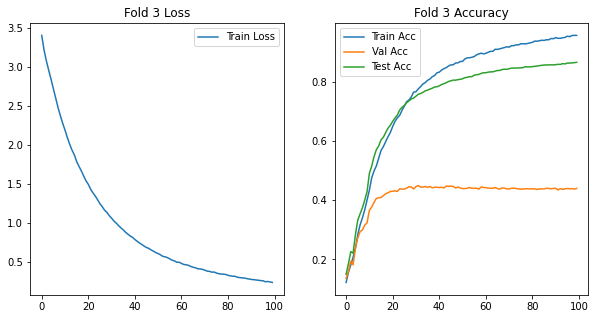

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.4037, Train Acc=0.0995, Val Acc=0.1482, Test Acc=0.1536
Fold 4/5, Epoch 2: Train Loss=3.2057, Train Acc=0.1512, Val Acc=0.1682, Test Acc=0.1877
Fold 4/5, Epoch 3: Train Loss=3.0642, Train Acc=0.1776, Val Acc=0.1760, Test Acc=0.1965
Fold 4/5, Epoch 4: Train Loss=2.9467, Train Acc=0.1992, Val Acc=0.1833, Test Acc=0.2163
Fold 4/5, Epoch 5: Train Loss=2.8180, Train Acc=0.2396, Val Acc=0.2460, Test Acc=0.3014
Fold 4/5, Epoch 6: Train Loss=2.7026, Train Acc=0.2848, Val Acc=0.2877, Test Acc=0.3410
Fold 4/5, Epoch 7: Train Loss=2.5922, Train Acc=0.3155, Val Acc=0.3017, Test Acc=0.3567
Fold 4/5, Epoch 8: Train Loss=2.4700, Train Acc=0.3470, Val Acc=0.3149, Test Acc=0.3849
Fold 4/5, Epoch 9: Train Loss=2.3588, Train Acc=0.3846, Val Acc=0.3231, Test Acc=0.4135
Fold 4/5, Epoch 10: Train Loss=2.2676, Train Acc=0.4189, Val Acc=0.3744, Test Acc=0.4843
Fold 4/5, Epoch 11: Train Loss=2.1698, Train Acc=0.4534, Val Acc=0.3893, Test Acc=0.5044
Fold 4/

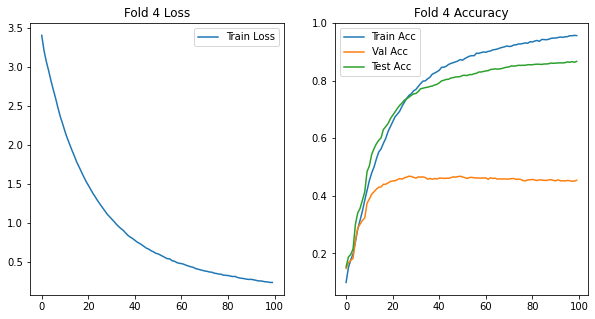

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.4032, Train Acc=0.1092, Val Acc=0.1623, Test Acc=0.1839
Fold 5/5, Epoch 2: Train Loss=3.2198, Train Acc=0.1553, Val Acc=0.1701, Test Acc=0.1903
Fold 5/5, Epoch 3: Train Loss=3.0712, Train Acc=0.1771, Val Acc=0.1899, Test Acc=0.2167
Fold 5/5, Epoch 4: Train Loss=2.9535, Train Acc=0.2030, Val Acc=0.1991, Test Acc=0.2439
Fold 5/5, Epoch 5: Train Loss=2.8368, Train Acc=0.2386, Val Acc=0.2678, Test Acc=0.3163
Fold 5/5, Epoch 6: Train Loss=2.7067, Train Acc=0.2923, Val Acc=0.2871, Test Acc=0.3378
Fold 5/5, Epoch 7: Train Loss=2.5915, Train Acc=0.3151, Val Acc=0.3063, Test Acc=0.3582
Fold 5/5, Epoch 8: Train Loss=2.4737, Train Acc=0.3419, Val Acc=0.3229, Test Acc=0.3780
Fold 5/5, Epoch 9: Train Loss=2.3627, Train Acc=0.3759, Val Acc=0.3246, Test Acc=0.4007
Fold 5/5, Epoch 10: Train Loss=2.2645, Train Acc=0.4146, Val Acc=0.3446, Test Acc=0.4541
Fold 5/5, Epoch 11: Train Loss=2.1679, Train Acc=0.4500, Val Acc=0.3858, Test Acc=0.5058
Fold 5/

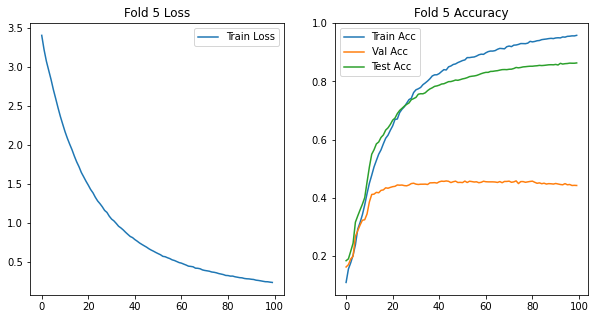

In [11]:
num_epochs = 100
k = 5

Model = k_fold_cross_validation(train_dataset.dataset, test_loader, k, num_epochs, batch_size, device=device, shuffle=True)

In [12]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=12

In [13]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [14]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.8693
Test Accuracy: 0.8766
Test Accuracy: 0.8655
Test Accuracy: 0.8670
Test Accuracy: 0.8632


In [15]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([ 2, 18,  8,  1, 22,  8, 15, 21,  1, 23, 16,  1, 22,  8, 14, 21, 21, 27,
        24, 15, 15,  8, 18,  1,  1, 13, 18, 16, 13,  1, 25,  7, 24, 23, 10, 14,
        26, 25,  2, 24,  8, 29, 18, 21, 13, 15,  4,  7,  1, 27,  1, 13, 20, 24,
         1,  2, 15, 27,  8, 27,  7, 29, 15,  2,  8, 13, 15,  0, 27, 27, 15, 14,
        16, 14, 21, 29,  2, 27, 24, 29, 16, 16, 18, 16, 21, 29, 12,  2, 23, 32,
        16,  4,  8, 26, 20, 29, 27, 24,  2, 29, 29,  0, 18, 15, 26, 29, 28, 13,
         6, 15,  1,  0,  1, 29, 28,  4,  2, 19, 13, 24,  8,  1,  1,  1,  7,  1,
         1, 15], device='cuda:0')
tensor([ 2, 18,  8,  1, 22,  8, 15, 21,  1, 23, 16,  1, 22,  8, 14, 21, 21, 20,
        24, 15, 15, 25,  7,  1,  0, 13, 18, 24, 13,  1, 25,  7, 24, 23, 10, 14,
        26, 25,  2, 24,  8, 29, 18, 21, 13, 15, 10,  7,  1, 26,  1, 13, 20, 24,
         1,  2, 15, 21,  8, 27,  7, 29, 15,  2,  8, 13, 15,  0, 27,  1, 15, 14,
        16, 14, 21, 29,  2, 27, 24, 29, 16,  8, 23, 16, 21, 29,  7,  2, 23, 32,
      